## Check  dataloader

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import skimage
labels_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/labels.npy"
instance_maps = np.load(labels_path)[0,:,:,0]

In [3]:
instance_maps

array([[114, 114, 114, ...,   0,   0,   0],
       [114, 114, 114, ...,   0,   0,   0],
       [114, 114, 114, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 120, 120, 120],
       [  0,   0,   0, ..., 120, 120, 120],
       [  0,   0,   0, ..., 120, 120,   0]], dtype=uint16)

In [4]:
np.unique(instance_maps)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145], dtype=uint16)

In [32]:
import numpy as np
from scipy.spatial.distance import euclidean

def calculate_object_probabilities(instance_segmentation_map, n_directions = 8):
    """
    Calculate object prob for each pixel in the image.
    Args:
    - instance_segmentation_map: A 2D numpy array representing the instance segmentation map.
    Returns:
    - object_probabilities: A 2D numpy array of the same shape as the input image with object probabilities.
    """

    # init the object probs with zeros
    object_probabilities = np.zeros_like(instance_segmentation_map, dtype=float)
    # Calculate the angle increment between radial directions
    angle_increment = 360 / n_directions

    # iterate over each instance
    for inst in np.unique(instance_maps)[1:]:
        instance_pixels = (instance_segmentation_map == inst)
        boundary_pixels = skimage.segmentation.find_boundaries(instance_pixels, 2, mode='outer', background=0)
        # iterate over each pixel in the instance
        for i in range(instance_segmentation_map.shape[0]):
            for j in range(instance_segmentation_map.shape[1]):
                if instance_pixels[i,j]:
                    distances_to_background = np.linalg.norm(
                    np.argwhere(boundary_pixels) - np.array([i, j]), axis=1
                    )
                    min_distance = np.min(distances_to_background)
                    # Normalize the distance to [0, 1]
                    object_probabilities[i, j] = min_distance / distances_to_background.max()

                    # Iterate over each radial direction
                    for i in range(n_directions):
                        # Calculate the angle in radians for the current direction
                        angle_rad = np.deg2rad(i * angle_increment)

                        # Initialize the current position to the center pixel
                        current_position = np.array([i,j])

                        # Extend a line in the current direction
                        while True:
                            # Calculate the next position along the line
                            next_position = current_position + np.array([np.cos(angle_rad), np.sin(angle_rad)], dtype=int)

                            # Check if the next position is a boundary pixel
                            if tuple(next_position) in boundary_pixels:
                                # Calculate the Euclidean distance and append to the distances list
                                distance = euclidean(center_pixel, tuple(next_position))
                                distances.append(distance)
                                break

                            # Update the current position for the next iteration
                            current_position = next_position

    return object_probabilities


In [33]:
object_probabilities = calculate_object_probabilities(instance_maps)

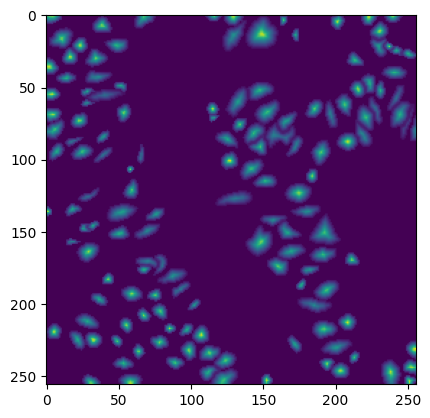

In [35]:
plt.imshow(object_probabilities)

In [36]:
np.max(object_probabilities)

0.7730206825239258

In [10]:
instance_maps[0,0]

()

In [17]:
label_image = np.array([[False, False, False],[False, True, False],[False, False, False]])

In [22]:
skimage.segmentation.find_boundaries(label_image, 2, mode='outer', background=0)

array([[ True,  True,  True],
       [ True, False,  True],
       [ True,  True,  True]])